## Loading in the data 

For more information, view URLs-preprocess notebook.

In [1]:
import pandas as pd

postings1 = pd.read_csv("../input/Postings_01052019_15052019.csv", delimiter=";")
postings2 = pd.read_csv("../input/Postings_16052019_31052019.csv", delimiter=";")

urls_df_1 = pd.read_csv("URLs-Postings_01052019_15052019.csv").set_index('Unnamed: 0')
urls_df_1.index.names = [None]

urls_df_2 = pd.read_csv("URLs-Postings_16052019_31052019.csv").set_index('Unnamed: 0')
urls_df_2.index.names = [None]

merged1 = pd.concat([postings1, urls_df_1], axis=1)
merged2 = pd.concat([postings2, urls_df_2], axis=1)

merged = pd.concat([merged1, merged2])
merged = merged.reset_index()
merged = merged.drop(['index'], axis=1)

merged = merged[merged['url'].notna()]

## Additional information: Observe users with most URL data

The less URLs that the users have posted each, the more likely their URL similarities could be attributed to chance. The following filters for users with most URLs posted where this will present least of an issue.

### Total link counts

In [2]:
merged.groupby(["ID_CommunityIdentity"]).count()["url"].sort_values(ascending=[False]).head(10)

ID_CommunityIdentity
500699    175
538958    120
679687    114
633296    112
586587    108
55475      98
530746     94
569277     94
633859     90
654549     87
Name: url, dtype: int64

### Unique URLs

In [3]:
group_count = merged.groupby(["ID_CommunityIdentity"]).nunique()
group_count["url"].sort_values(ascending=[False]).head(10)

ID_CommunityIdentity
500699    148
538958    107
586587    104
679687    102
633296     88
569277     88
530746     87
55475      87
633859     73
243821     72
Name: url, dtype: int64

### Unique Domains that the links belong to

In [4]:
group_count["domain"].sort_values(ascending=[False]).head(10)

ID_CommunityIdentity
500699    77
530746    61
633296    58
586587    57
679687    57
579846    54
571425    46
579842    44
96494     43
633859    42
Name: domain, dtype: int64

## Code for calculating Jaccard Coefficient

The following contains code for calculating the JC. Follow the comments in the code chunks in order to understand the rough reasoning behind the respective lines of code.

In [5]:
#splits up the dataset in df equal groups and creates a new column (named 0) assigning distinct numbers to each of the groups so it's possible to perform group operations afterwards
def equal_groups(df, chunks):
    amount_rows = df.shape[0]
    chunks = pd.Series(range(amount_rows)).apply(lambda x: int(x/(amount_rows/chunks)))
    chunks.index = df.index
    return pd.concat([chunks,df],axis=1)

In [6]:
def get_jaccard_coeffs(user1, user2, chunks=1, df=merged, column="domain"):
    #join rows containing user1 and user2 into one common table
    dfx = pd.concat([df[df["ID_CommunityIdentity"] == user1], df[df["ID_CommunityIdentity"] == user2]])
    dfx = dfx.reset_index()
    dfx = dfx.drop(['index'], axis=1)
    #split into three equal sized groups
    eg_dfx = equal_groups(dfx, chunks)
    #filter for user1 and user2 respectively
    eg_dfx1 = eg_dfx[eg_dfx["ID_CommunityIdentity"] == user1]
    eg_dfx2 = eg_dfx[eg_dfx["ID_CommunityIdentity"] == user2]
    #for each chunk, calculate Jaccard Coefficient
    similarities = []
    for chunk in range(chunks):
        dfx_intersect = set(eg_dfx1[eg_dfx1[0] == chunk][column]).intersection(set(eg_dfx2[eg_dfx2[0] == chunk][column]))
        dfx_union = set(eg_dfx1[eg_dfx1[0] == chunk][column]).union(set(eg_dfx2[eg_dfx2[0] == chunk][column]))
        similarities.append(len(dfx_intersect) / len(dfx_union))
    return similarities

## Use Cases

### Use Case 1: Determine Domains similarities between two users

The following displays the similarities between the two users, based off of the domains of the links that the users had posted. 

I chose to go with "domains" to be the default similarity measure as opposed to "urls" for the reason that they appeared more useful in my analysis so far, as it's more likely to find the same or similar domains posted by users as opposed to exact links.

In [23]:
get_jaccard_coeffs(538958, 586587)

[0.09210526315789473]

### Use Case 2: Determine URLs similarities between two users

The following shows how to change the default of determining the domains similarities to urls similarities.

In [26]:
get_jaccard_coeffs(538958, 586587, column="url")

[0.0]

As you can see, the url similarities of the users with the second and third most common url counts is zero.

### Extra: Determine Domain similarities over time

The following shows how to determine url similarities over time. This may or may not be very useful due to the scarce nature of links posted in comments in general, but the functionality exists.

In [29]:
get_jaccard_coeffs(538958, 586587, 3)

[0.0, 0.0967741935483871, 0.0]

This can then also be visualized with the help of matplotlib:

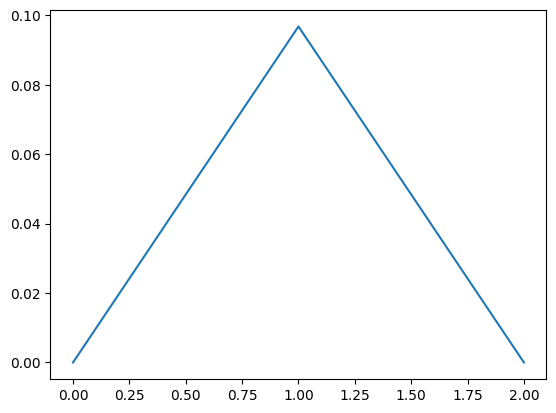

In [30]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
ax.plot(get_jaccard_coeffs(538958, 586587, 3))